In [7]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Conectar con MLflow local
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()

In [3]:
# Función para obtener el historial de una métrica por step de una run
def get_metric_history(run_id, metric_name):
    history = client.get_metric_history(run_id, metric_name)
    return pd.DataFrame([{"step": m.step, metric_name: m.value} for m in history])

# Función para concatenar métricas de varias runs secuenciales
def concatenar_runs(run_ids, metric_names):
    dfs = []
    step_offset = 0

    for run_id in run_ids:
        df_parts = []
        for metric in metric_names:
            df_metric = get_metric_history(run_id, metric)
            df_metric.set_index("step", inplace=True)
            df_parts.append(df_metric)
        
        df = pd.concat(df_parts, axis=1).reset_index()

        # Ajustar los steps para que continúen secuencialmente
        df["step"] = df["step"] + step_offset
        step_offset = df["step"].iloc[-1] + 1

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

In [4]:
# --- Concatenar A2C (de 0 a 36.6M timesteps) ---
a2c_run_ids = [
    "196919f796824d74aefce46a20d0c44f",  # 0 a 10M
    "d29144d2e70447c5887a0bcd125c2b1a",  # 10M a 16.6M
    "f445012c13154edcbadfe3ed0f7187ef"   # 16.6M a 36.6M
]

df_a2c_concat = concatenar_runs(a2c_run_ids, ["episode_reward_mean", "episode_reward_std"])


# --- Concatenar PPO (de 0 a 29.7M timesteps) ---
ppo_run_ids = [
    "d5750967396d4e5b97e4ef2e72979f21",  # 0 a 10M
    "95c2decd982545278b2929f016ad6d44",  # 10M a 17.5M
    "fcb164f883fe4ab2ad719a0fe176d493"   # 17.5M a 29.7M
]

df_ppo_concat = concatenar_runs(ppo_run_ids, ["episode_reward_mean", "episode_reward_std"])

# --- DQN (una única run) ---
dqn_run_id = "914f23523dcf4539966b840d8b4d6955"
df_dqn_concat = concatenar_runs([dqn_run_id], ["episode_reward_mean", "episode_reward_std"])

# --- QRDQN (una única run) ---
qrdqn_run_id = "78cd4d25f19e4ed996d0d864f1969eb4"
df_qrdqn_concat = concatenar_runs([qrdqn_run_id], ["episode_reward_mean", "episode_reward_std"])


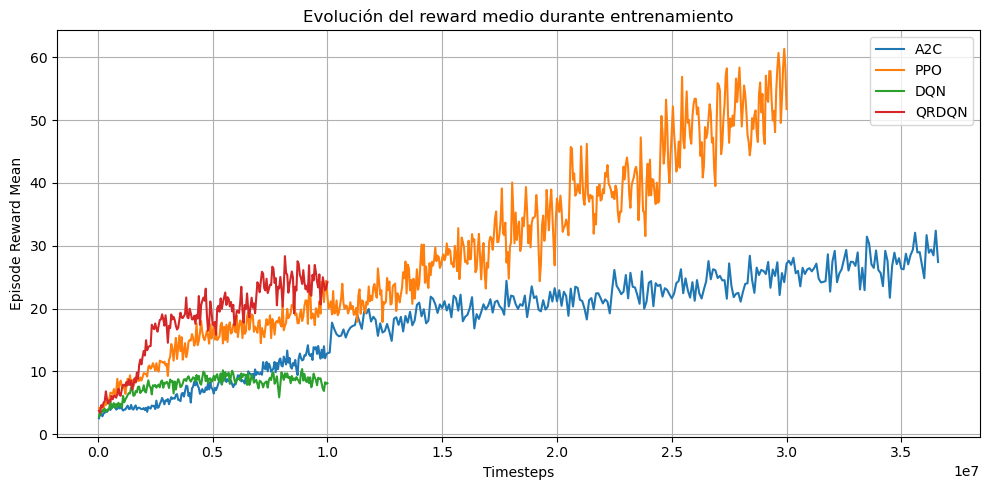

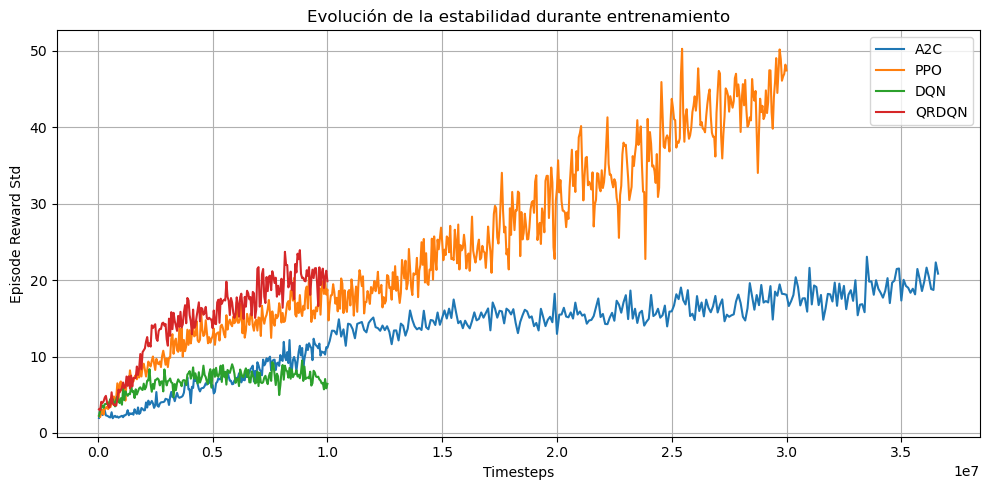

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat["step"], df_a2c_concat["episode_reward_mean"], label="A2C")
plt.plot(df_ppo_concat["step"], df_ppo_concat["episode_reward_mean"], label="PPO")
plt.plot(df_dqn_concat["step"], df_dqn_concat["episode_reward_mean"], label="DQN")
plt.plot(df_qrdqn_concat["step"], df_qrdqn_concat["episode_reward_mean"], label="QRDQN")

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat["step"], df_a2c_concat["episode_reward_std"], label="A2C")
plt.plot(df_ppo_concat["step"], df_ppo_concat["episode_reward_std"], label="PPO")
plt.plot(df_dqn_concat["step"], df_dqn_concat["episode_reward_std"], label="DQN")
plt.plot(df_qrdqn_concat["step"], df_qrdqn_concat["episode_reward_std"], label="QRDQN")

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Std")
plt.title("Evolución de la estabilidad durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [6]:
# Diccionario con los run_id finales de cada algoritmo
runs_finales = {
    "DQN": "914f23523dcf4539966b840d8b4d6955",
    "QRDQN": "78cd4d25f19e4ed996d0d864f1969eb4",
    "A2C": "f445012c13154edcbadfe3ed0f7187ef",  # última run concatenada
    "PPO": "fcb164f883fe4ab2ad719a0fe176d493"   # última run concatenada
}

datos = []

for nombre, run_id in runs_finales.items():
    run = client.get_run(run_id)
    metrics = run.data.metrics
    train = metrics.get("episode_reward_mean")
    test = metrics.get("test_reward")
    if train is not None and test is not None:
        diff = train - test
        datos.append({
            "Algoritmo": nombre,
            "Train Reward": round(train, 2),
            "Test Reward": round(test, 2),
            "Diferencia (Train - Test)": round(diff, 2)
        })

# Mostrar tabla
df_comparacion = pd.DataFrame(datos)
df_comparacion.sort_values("Algoritmo", inplace=True)
df_comparacion.reset_index(drop=True, inplace=True)
df_comparacion


,Algoritmo,Train Reward,Test Reward,Diferencia (Train - Test)
0,A2C,27.42,31.51,-4.09
1,DQN,8.12,8.01,0.11
2,PPO,51.77,38.41,13.36
3,QRDQN,24.23,26.55,-2.32


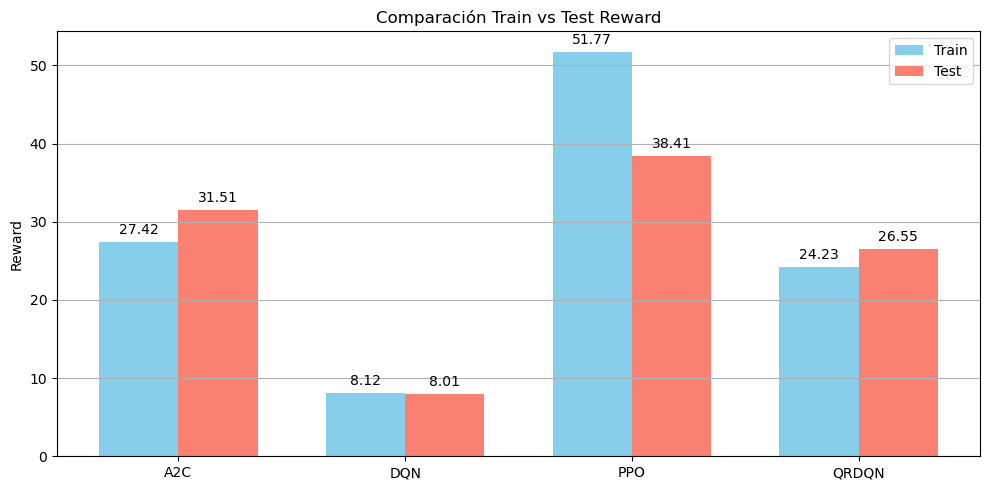

In [8]:
# Crear la gráfica
algoritmos = df_comparacion["Algoritmo"]
train = df_comparacion["Train Reward"]
test = df_comparacion["Test Reward"]
diff = df_comparacion["Diferencia (Train - Test)"]

x = np.arange(len(algoritmos))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train, width, label="Train", color="skyblue")
plt.bar(x + width/2, test, width, label="Test", color="salmon")

for i in range(len(x)):
    plt.text(x[i] - width/2, train[i] + 1, f"{train[i]}", ha='center')
    plt.text(x[i] + width/2, test[i] + 1, f"{test[i]}", ha='center')

plt.xticks(x, algoritmos)
plt.ylabel("Reward")
plt.title("Comparación Train vs Test Reward")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Conclusiones

PPO logra el mejor rendimiento general, pero con mayor variabilidad en el comportamiento a medida que avanza el entrenamiento.

A2C tiene un crecimiento más lento y controlado, reflejando un aprendizaje más estable pero menos ambicioso.

DQN y QRDQN parecen limitarse en capacidad de mejora, estabilizándose pronto sin llegar al rendimiento de PPO o A2C.

La evolución de std respalda la conclusión: más reward = más riesgo (PPO), mientras que menos reward puede significar más consistencia (A2C).

PPO es el algoritmo más recomendable, por su alto rendimiento medio, buen uso de recursos y capacidad de generalización, a pesar de su variabilidad.
A2C es una buena segunda opción si se prioriza estabilidad
Se desaconseja el uso de DQN en este entorno sin cambios sustanciales en diseño o configuración.